# **Recommender Systems**



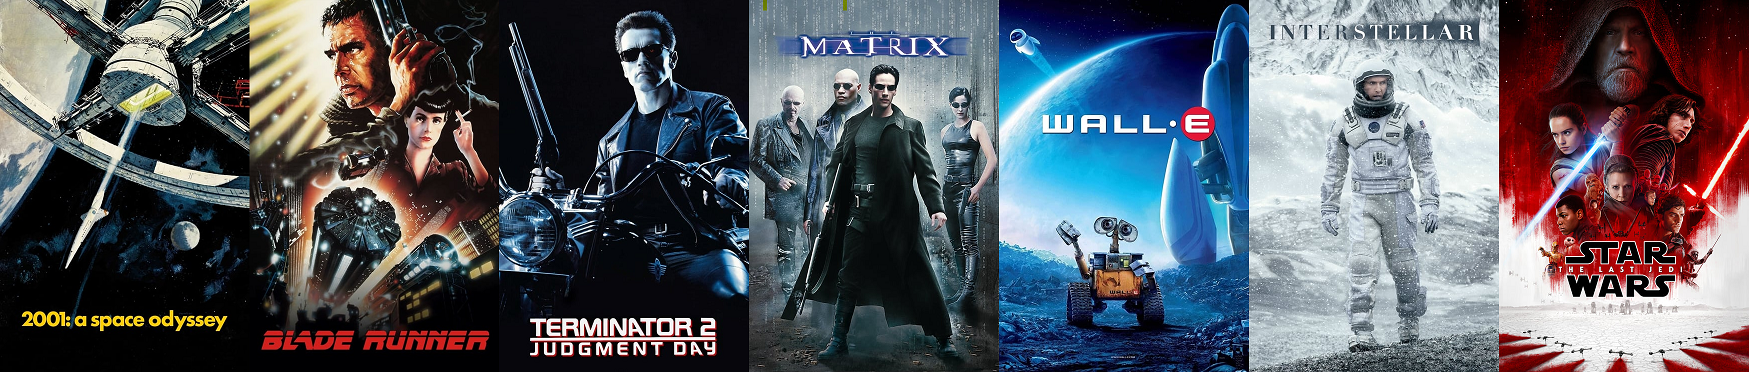


Adapted from the [repository](https://github.com/deep-learning-indaba/indaba-pracs-2024) (rewritten to use Pytorch instead of Jax).

**Authors:** [Amrit Purshotam](https://nl.linkedin.com/in/amritpurshotam)

**Reviewers:**
[Matthew Morris](https://www.cs.ox.ac.uk/people/matthew.morris/), Zakaria Sawadogo

**Introduction:**

Recommender Systems are probably one of the most ubiquitous type of machine learning model that we encounter in our online life. They influence what we see in our social media feeds, the products we buy, the music we listen to, the food we eat, and the movies we watch. In this prac, we take you through some of the techniques popularly used in industry that recommends the content you see online by building our very own movie recommender system.

**Topics:**

Content: Machine Learning, Recommender Systems, Approximate Nearest Neighbours

**Aims/Learning Objectives:**

- General architecture of a recommender system.
- Techniques for making recommendations.
- Serving recommendations efficiently in production.

## Installation, Imports, and Data Preparation

In [ ]:
# @title Install required packages  (Run once)
!pip install annoy

In [ ]:
# @title Import required packages  (Run every time you restart)
import os, sys, zipfile, requests, random
from typing import Iterable, Mapping, Tuple, Sequence, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class MovieLensDataset:
    def __init__(self, dataset: str):
        self.dataset = dataset
        self.filename = f"{self.dataset}.zip"
        self.raw_dir = "./recsys_data/raw"
        self.full_raw_path = f"{self.raw_dir}/{self.filename}"

    def download_raw(self, chunk_size: int = 1024):
        os.makedirs(self.raw_dir, exist_ok=True)
        if os.path.isfile(self.full_raw_path):
            print(f"{self.filename} already exists.")
            return
        url = f"https://files.grouplens.org/datasets/movielens/{self.filename}"
        resp = requests.get(url, stream=True)
        total = int(resp.headers.get("content-length", 0))
        with open(self.full_raw_path, "wb") as file, tqdm(
            desc=self.full_raw_path,
            total=total,
            unit="iB",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in resp.iter_content(chunk_size=chunk_size):
                bar.update(file.write(chunk))

    def extract(self):
        out_dir = f"{self.raw_dir}/{self.dataset}"
        if os.path.isdir(out_dir):
            print(f"{self.filename} already extracted.")
            return
        with zipfile.ZipFile(self.full_raw_path, "r") as zf:
            zf.extractall(self.raw_dir)

    def to_pandas(self):
        movies = pd.read_csv(f"{self.raw_dir}/{self.dataset}/movies.csv")
        ratings = pd.read_csv(f"{self.raw_dir}/{self.dataset}/ratings.csv")
        movies = movies.rename(
            {"movieId": "movie_id", "title": "movie_title"}, axis=1
        ).drop(columns="genres")
        ratings = ratings.rename(
            {"userId": "user_id", "movieId": "movie_id", "rating": "user_rating"},
            axis=1,
        )
        ratings = ratings.merge(movies, on="movie_id")
        return ratings, movies


In [ ]:
# @title Helper methods
if not os.path.exists("./recsys_data/posters"):
    os.makedirs("./recsys_data", exist_ok=True)

def download_posters():
    if os.path.isfile("./recsys_data/posters.zip"):
        print("Posters already downloaded. Skipping…")
        return
    url = (
        "https://drive.usercontent.google.com/download?"
        "id=15ipM74Qdc74d25jRQ3Mf4yB79tZqSkjU&authuser=0&confirm=t"
    )
    resp = requests.get(url, stream=True)
    with open("./recsys_data/posters.zip", "wb") as f:
        for chunk in resp.iter_content(chunk_size=10 * 1024):
            f.write(chunk)

def unzip_posters():
    if os.path.isdir("./recsys_data/posters"):
        print("posters.zip already extracted. Skipping…")
        return
    with zipfile.ZipFile("./recsys_data/posters.zip", "r") as zf:
        zf.extractall("./recsys_data/")

def cross_tabulate(df: pd.DataFrame, num_samples: int = 10) -> pd.DataFrame:
    pivot = df.pivot(index="user_id", columns="movie_id", values="user_rating")
    pivot = pivot.loc[
        df["user_id"].sample(num_samples), df["movie_id"].sample(num_samples)
    ].dropna(axis=0, thresh=1).fillna("")
    return pivot

def make_mapping(id_set: Iterable[str]) -> Mapping[str, int]:
    return {s: i for i, s in enumerate(id_set)}

def densify_column_values(
    df: pd.DataFrame, col_name: str
) -> Tuple[pd.Series, Sequence[str], Dict[str, int]]:
    vals = sorted(set(df[col_name]))
    mapping = make_mapping(vals)
    return df[col_name].map(mapping), vals, mapping

def get_train_val_split(df: pd.DataFrame, val_frac: float = 0.2):
    val_df = df.sample(frac=val_frac, random_state=SEED)
    train_df = df.drop(val_df.index)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

def plot_metric_history(hist: dict):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title("Loss")
    ax.plot(hist["train_loss"], label="train_loss")
    ax.plot(hist["val_loss"], label="val_loss")
    ax.legend(); plt.show(); plt.clf()

def make_movie_lookup(df: pd.DataFrame):
    tmp = df[["movie_id", "movie_title"]].drop_duplicates("movie_id")
    return dict(zip(tmp.movie_id, tmp.movie_title))


In [ ]:
class Config:
    DATASET = "ml-latest-small"
    SEED = 42
    EMB_DIM = 50
    LR = 5e-3
    BATCH_SIZE = 64
    NUM_EPOCHS = 20
    WEIGHT_DECAY = None   # set later when needed

cfg = Config()
torch.manual_seed(cfg.SEED)


## **1. Recommender Systems Overview**

### **1.1 A Real World Scenario**

Imagine you're going shopping for a new book. You enter the store and start walking around scanning the shelves of books. Something catches your interest, you pause, take the book down and inspect the cover, and perhaps also read the blurb. You continue to do this until you find something you like at which point you purchase the book and leave.

Now imagine you've read the book and quite enjoyed it and you want to buy another one. You go back to the store, browse around, and occasionally inspect some books that catch your interest. An assistant this time approaches you asking if you need help. Gladly you accept, and you mention the books you were looking at as well as the one that you purchased recently. Since they've been working there a long time and have helped many customers, they now have a good idea of what you may like and recommends a short list of books for you to look at. You do so and eventually settle on one to purchase.

**Exercise**. Let's pause here for a moment and dig deeper into this scenario.

- From all the books in the store, what does it say about the ones you paused to look at, the ones you ignored, and the ones you purchased?
- What does it say about you as the reader and your preferences? Could there be other people like you?
- How was the assistant able to narrow down all the books in the store to just a few from which you actually purchased one?

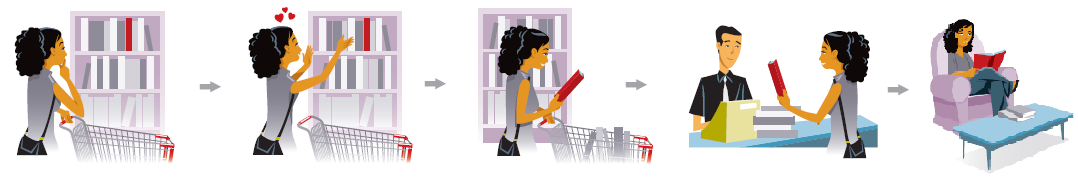

Source: Kim Falk. *Practical Recommender Systems*. 2019. Manning.

The answer to these questions is now getting into the heart of recommender systems. Your behaviour probably wasn't random but instead had some structure and logic to it. You also likely have particular preferences to some genres and/or authors. Without even knowing anything else about the books, this follows then that the books you looked at and purchased matched those preferences and the ones you ignored more likely did not. Additionally, based on your preferences, what was catching your interest, and what you previously read, the store assistant was able to stitch together a rough profile of you. She then thought about her previous customers similar to you and what they had previously purchased. This is how she was then able to shortlist relevant books for you to look at.

As you probably guessed it by now, the store assistant is the recommender system in this example. Instead of a person though, we want to build something that is able to learn the latent structure between all the books, all our customers, and how well they match each other in order to then make our recommendations. In the following sections we will learn how to do this. But first let's go over the general architecture of a recommender system.

### **1.2 Recommendation System Architecture**

#### **1.2.1 Overview**

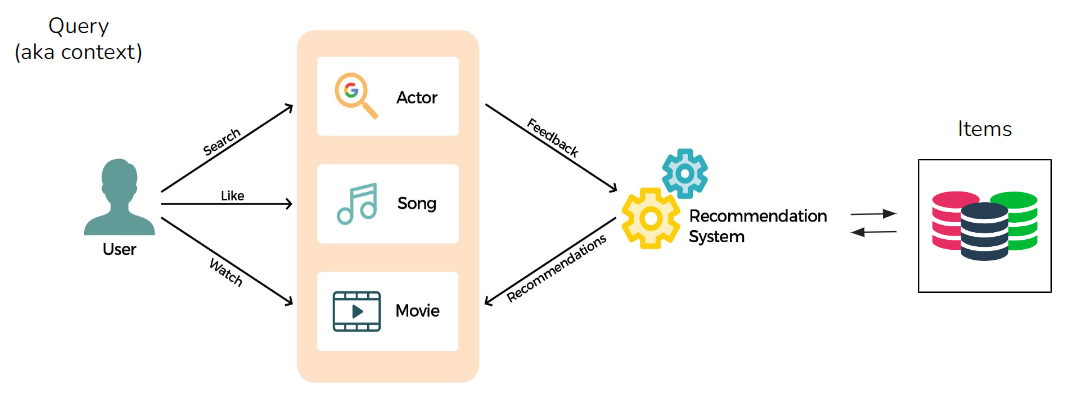

Source: [*Recommendation System Design*](https://medium.com/double-pointer/system-design-interview-recommendation-system-design-as-used-by-youtube-netflix-etc-c457aaec3ab). 2021. Medium.

The above diagram generalises our previous scenario from books to searches, songs, and movies (note there will usually only be one) while the user is you as before. Notice how the user interacts with these *items* which then gets sent to the recommender system as feedback. The recommender system processes this, retrieves relevant items from its database and then serves them to the user. The user, in turn, further interacts with these items and continues this loop until some terminating criteria. Perhaps they found a movie they like and started watching, or they purchase a book like in our previous example, or they simply leave.

Finally, you may have noticed some new terminology in the diagram, the *query / context* on the user side of diagram. This is a further generalisation of what we're retrieving relevant items for. In this example it's the user but it can also include their previous searches, item interactions, the time of day, the device they're using, or any of combination of them.

#### **1.2.2 Zooming in**

Let's zoom in closer to the recommender system now by having a look at how YouTube described theirs back in 2016 in their seminal paper on the topic. Being YouTube, the items here would be videos which number in the millions (and most likely in the billions as of writing in 2023). Pay special attention to the blue stages, notice the number of items going into each stage going down and hence the funnel shape.

Looking at the first one, the job of the *candidate generation* stage is to efficiently *retrieve* relevant items from your database (which is why you may find in the literature, this stage is also known as *retrieval*). Speed is of the utmost importance here so some leeway is allowed in terms of relevancy as long as the number of items we reduce down to is manageable for the downstream parts of the recommender. This lookup speed is achieved partly by the techniques we discuss and implement later in this practical but also by limiting the number of features that feed into this stage.

The second *ranking* stage (also known as *scoring*) then takes these items and sorts them based on additional features that come from the user as well as the features of the item itself to optimise for some target we care about. In the case of YouTube, it will be for watch time, or in the case of an e-commerce website, the likelihood to purchase the items. Another reason for a ranking stage is that you may have multiple candidate generators and you now need a way to combine the results in some optimal way, at which point they're then shown to the user. It's also important to note, this ranking stage is not always necessary. Sometimes the retrieval step is good enough and you can keep the complexity of the system down, reduce implementation times, lower maintenance overhead, and therefore costs.

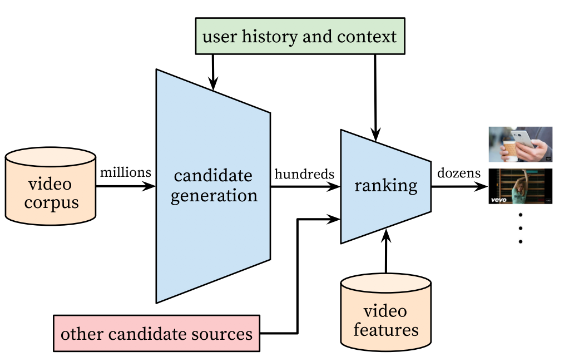

Source: Covington et. al. [*Deep Neural Networks for YouTube Recommendations*](https://research.google/pubs/pub45530/). 2016. Proceedings of the 10th ACM Conference on Recommender Systems.

Finally, this last diagram, courtesy of the recommendations team at NVIDIA, further expands on the above ideas by defining two more stages namely *filtering* and *ordering*. After the retrieval / candidate generation stage, we may find that some of the items, while relevant, aren't useful and so need to be filtered out. In an e-commerce scenario this could be an item that's out of stock or in the case of a social media platform, a post coming from a person or topic you've blocked / muted. The *ordering* step which takes place after ranking / scoring then refers to further refining the order of the items depending on some business logic. For example, promoting on sale items or perhaps even sponsored placements.

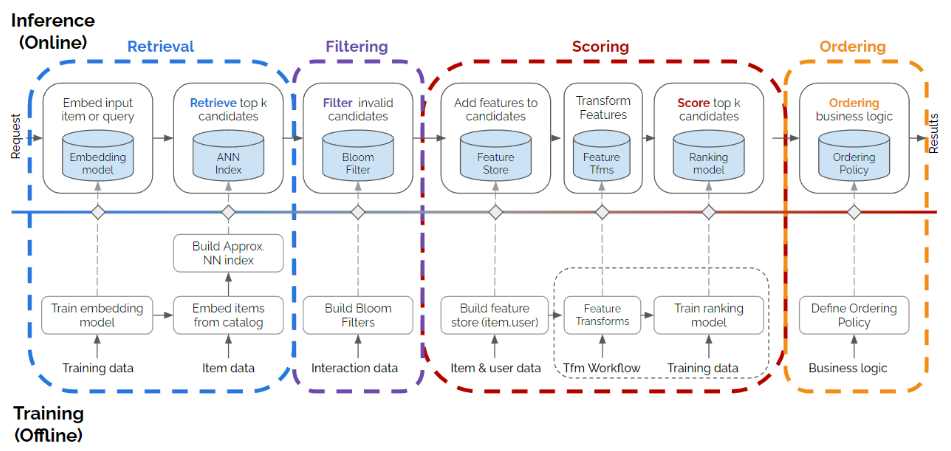

Source: Even Oldridge. [*Recommender Systems, Not Just Recommender Models*](https://medium.com/nvidia-merlin/recommender-systems-not-just-recommender-models-485c161c755e). 2022. Medium.

The rest of this practical will now focus primarily on the retrieval / candidate generation stage of a recommender system. We hope this introduction and overview of recommender systems helps put into context the specific piece we will be building out. In particular, we will be learning about Collaborative Filtering and Graph Neural Networks for recommendations.

## **2. Collaborative Filtering**

### **2.1 Overview**

Collaborative Filtering is a technique that learns how to recommend items to user A based on the interests of a similar user B by using similarities between these users and items simultaneously. This is opposed to content-based filtering that uses hand-engineered and/or explicit features of an item for further recommendations for e.g. recommending a movie in the same genre of one who you already watched.

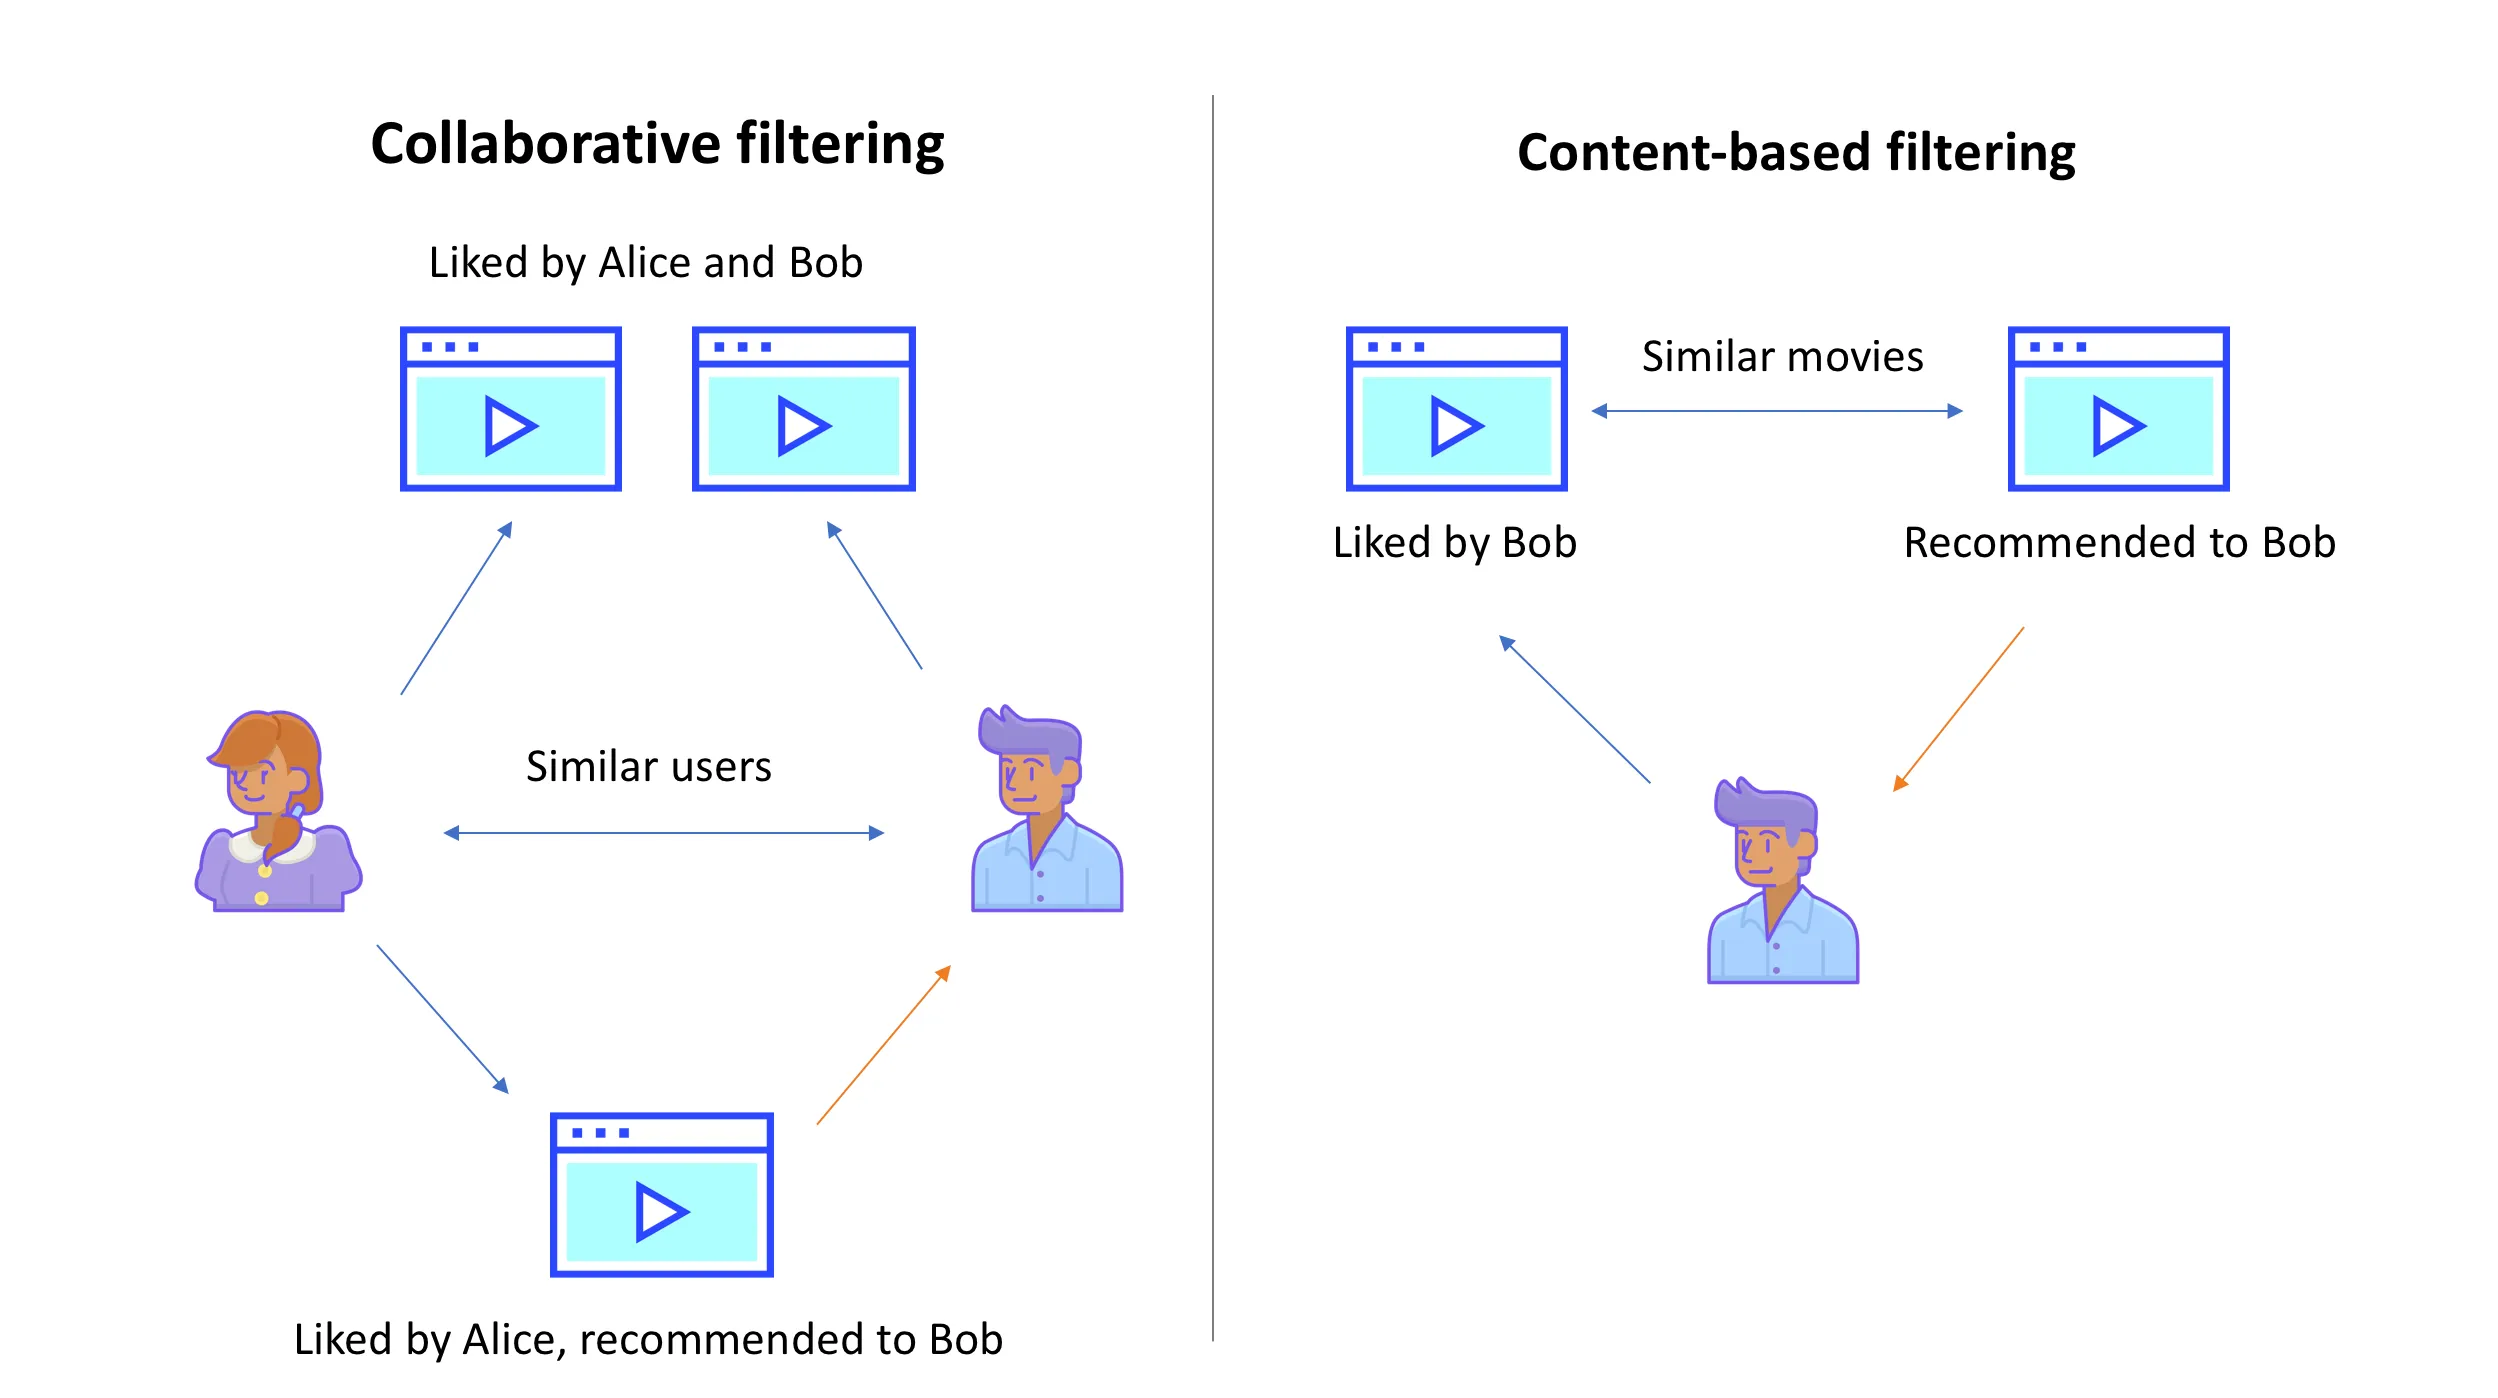

Source: Arthur Mello. [*How do Netflix and Amazon know what I want?*](https://towardsdatascience.com/how-do-netflix-and-amazon-know-what-i-want-852c480b67ac). 2020. Medium.

### **2.2 Matrix Factorisation**

Consider a movie recommendation system in which the training data consists of a feedback matrix $A ∈ R^{m × n}$ where $m$ is the number users and $n$ is the number of items. Each row then represents a user and each column represents an item (a movie) with the entries indicating a user's rating of a particular movie. Our goal then is to learn
- A user embedding matrix $U ∈ \mathbb{R}^{m × d}$, where row $i$ is the embedding for user $i$ and $d$ is the length of the embedding.
- An item embedding matrix $V ∈ \mathbb{R}^{n × d}$, where row $j$ is the embedding for item $j$ and $d$ is the length of the embedding.

such that their product $UV^{T}$ is a good approximation of the feedback matrix $A$. Note that the $(i, j)$ entry of $UV^{T}$ is simply the dot product of $⟨ U_i, V_j ⟩$ of the embeddings of user $i$ and item $j$ which you want to be as close as possible to $A_{ij}$. This process of finding these matrices $U$ and $V$ is known as *matrix factorisation*.

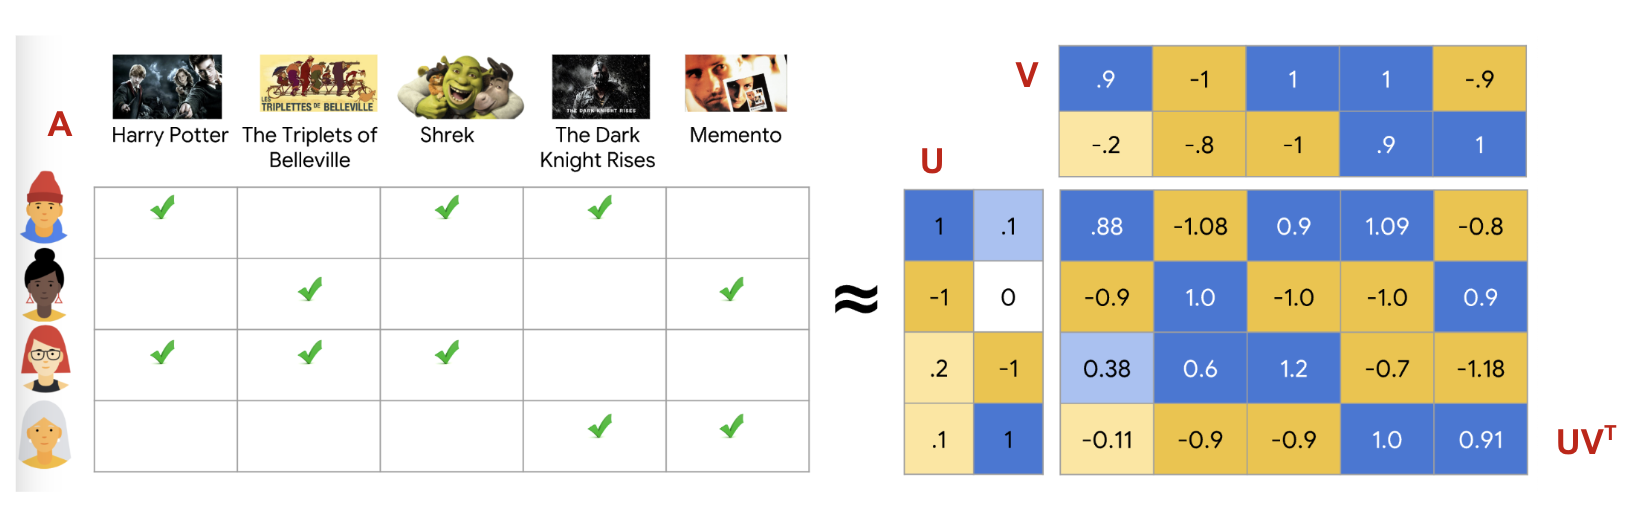

Source: [*Google Recommendation Systems Course*](https://developers.google.com/machine-learning/recommendation/collaborative/matrix).

Take special note how the matrices $U$ and $V$ give a more compact representation of the full matrix, even in this toy example (in practice $d$ is much smaller than $m$ and $n$ since you will have many more users and items). As a result, this process finds latent structure in the data without even requiring any knowledge of the movies themselves!

Now, there are two common algorithms for finding these matrices, namely
- Stochastic Gradient Descent (SGD) which is a generic method to minimise loss functions
- Weighted Alternating Least Squares (WALS) which is specialised to this particular problem and works by alternating between fixing $U$ and solving for $V$ and vice versa.

For this practical, we'll be using SGD to learn these matrices which means we have to define a loss function. One intuitive function is the squared distance. To do this, we minimise the average of squared errors over all pairs of observed entries.

$ \frac{1}{|obs|} ∑_{(i,j) \in obs} (A_{ij} - ⟨ U_i, V_j ⟩)^2$

With this loss function defined, we can then randomly initialise our matrices $U$ and $V$, and through SGD iteratively update them until $UV^T$ is a good approximation of $A$. We now finally have all the pieces to move ahead with the rest of the tutorial.

### **2.3 The MovieLens Dataset**

Since we don't have access to an actual streaming service watch history, we will instead use a dataset called [MovieLens](https://grouplens.org/datasets/movielens/) and in particular the `latest-small-ratings` subset which contains 100 thousand ratings across 9 thousand movies and 600 users. Let's have a look.

In [ ]:
# @title Download, extract and load MovieLens
mld = MovieLensDataset(cfg.DATASET)
mld.download_raw(); mld.extract()

df, movies = mld.to_pandas()
movie_lookup = make_movie_lookup(df)

# Map raw IDs → dense integers starting at 0
df["user_id"], user_list, user2id = densify_column_values(df, "user_id")
df["item_id"], movie_list, movie2id = densify_column_values(df, "movie_title")

train_df, val_df = get_train_val_split(df)


As you can see, we have our users represented by the `user_id`, the movies (our items), and the `user_rating` out of 5 that the user gave that particular movie. We also have the `timestamp` of when the user rated the movie in unix time format which is the number of seconds that elapsed since 1 January 1970 UTC and a common way of representing time due to it's unambiguity.

Now what if we cross-tabulate a sample of this data to get an alternative view.

In [ ]:
cross_tabulate(df)

The table displayed shows some of the more popular movies and users. The empty cells are what we want our model to learn to fill in i.e. the movies we presume a user has not yet watched because they have yet to rate it. Then once we make these predictions, we can figure out which of those movies they're most likely to enjoy.

Looking at this table, you may have also noticed its sparsity. In reality, this table is actually even more so. Let's calculate how many cells are empty.

In [ ]:
num_users = df['user_id'].unique().shape[0]
num_items = df['movie_title'].unique().shape[0]
num_ratings = df.shape[0]
sparsity = 100 - (num_ratings / (num_users * num_items) * 100)
print(f"Sparsity: {sparsity:.2f}")



### **2.2 Dataset Preparation**

Now let's prepare our dataset for training. We will be mapping our users and movies from indexes starting from 0.

In [ ]:
df['user_id'], user_list, user_to_id_mapping = densify_column_values(df, 'user_id')
df['item_id'], movie_list, movie_to_id_mapping = densify_column_values(df, 'movie_title')
df.head(5)[['user_id', 'item_id', 'user_rating', 'timestamp']]

Then we will split our data randomly into a train and validation set and create our dataloaders that will feed data into our training process later. The exact details aren't too important here but if you're interested feel free to inspect these methods in the Helper methods cell near the top of this notebook.

In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.user_id = torch.tensor(dataframe["user_id"].values, dtype=torch.long)
        self.item_id = torch.tensor(dataframe["item_id"].values, dtype=torch.long)
        self.rating  = torch.tensor(dataframe["user_rating"].values, dtype=torch.float32)

    def __len__(self): return len(self.user_id)

    def __getitem__(self, idx):
        return {
            "user_id": self.user_id[idx],
            "item_id": self.item_id[idx],
            "user_rating": self.rating[idx],
        }

def prepare_dataloaders(batch_size: int):
    train_dl = DataLoader(
        RatingsDataset(train_df), batch_size=batch_size,
        shuffle=True, drop_last=False, num_workers=2
    )
    val_dl = DataLoader(
        RatingsDataset(val_df), batch_size=batch_size,
        shuffle=False, drop_last=False, num_workers=2
    )
    return train_dl, val_dl

train_dl, val_dl = prepare_dataloaders(cfg.BATCH_SIZE)
total_steps = len(train_dl) * cfg.NUM_EPOCHS


We are now ready to finally start implementing our Collaborative Filtering model.

### **2.3 Building our Model**

#### **2.3.1 Dot Product Model (Task)**

Let's start defining the architecture for this model in it's simplest formulation. Implement the below steps in the code cell below.
1. Define $m$ and $n$ which correspond to the number of users and items respectively.
2. Define $d$ corresponding to the dimension of the below embedding matrices.
3. Create and specify the shape of our embedding matrices. Recall $U ∈ \mathbb{R}^{m × d}$ and $V ∈ \mathbb{R}^{n × d}$ for the user and item embeddings respectively. Hint: [`nn.Embed`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.Embed.html)
4. Take the dot product of the user and item embeddings respectively. Hint: [`jnp.multiply`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.multiply.html) and [`jnp.sum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.sum.html) may be useful here.

In [ ]:
class CFDotProduct(nn.Module):
    def __init__(self, num_users: int, num_items: int, emb_dim: int):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

    def forward(self, batch):
        u = self.user_emb(batch["user_id"])
        i = self.item_emb(batch["item_id"])
        return (u * i).sum(dim=1)          # shape: [B]


Now that we have specified the shape of the model, we now have to define our loss function. Recall that this will be the mean squared error between our predicted ratings and the actual ratings. Since this loss is a reasonable metric as well to measure the performance of our model, we'll use it as well.

In [ ]:
# @title fit() + evaluate()
def fit(model, train_dl, val_dl, epochs, lr, weight_decay=None):
    model.to(DEVICE)
    criterion = nn.MSELoss()
    opt_class = AdamW if weight_decay else Adam
    optimizer = opt_class(model.parameters(), lr=lr, weight_decay=weight_decay or 0.0)
    scheduler = OneCycleLR(
        optimizer, max_lr=lr, total_steps=len(train_dl) * epochs,
        pct_start=0.25, div_factor=25.0, final_div_factor=1e5
    )

    hist = {"train_loss": [], "val_loss": []}
    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train(); running = 0.0
        for batch in train_dl:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            optimizer.zero_grad()
            preds = model(batch)
            loss = criterion(preds, batch["user_rating"])
            loss.backward(); optimizer.step(); scheduler.step()
            running += loss.item() * preds.size(0)
        hist["train_loss"].append(running / len(train_dl.dataset))

        # --- validate ---
        model.eval(); running = 0.0
        with torch.no_grad():
            for batch in val_dl:
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                preds = model(batch)
                running += criterion(preds, batch["user_rating"]).item() * preds.size(0)
        hist["val_loss"].append(running / len(val_dl.dataset))

        print(f"Epoch {epoch}: "
              f"train={hist['train_loss'][-1]:.4f}, "
              f"val={hist['val_loss'][-1]:.4f}")
    return hist


We are now ready to train our model!

In [ ]:
# @title Train CFDotProduct
model = CFDotProduct(num_users=len(user_list), num_items=len(movie_list), emb_dim=cfg.EMB_DIM)
hist = fit(model, train_dl, val_dl, cfg.NUM_EPOCHS, cfg.LR)
plot_metric_history(hist)

Since our ratings are between `0.5` and `5`, the first thing we can do to make this model a bit better is to force the predictions to be in this range. A useful function for this would be the [`sigmoid`](https://flax.readthedocs.io/en/v0.5.3/_autosummary/flax.linen.sigmoid.html) which constrains it's input to between `0` and `1`. Multiplying and shifting this then allows us to move these values to any range of values. Let's choose `0` and `5.5` since empirically these work better by expanding the range of allowed values.

In [ ]:
class CFWithRange(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, min_rating=0.0, max_rating=5.5):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.min_r = min_rating
        self.max_r = max_rating

    def forward(self, batch):
        u = self.user_emb(batch["user_id"])
        i = self.item_emb(batch["item_id"])
        y = (u * i).sum(dim=1)
        y = torch.sigmoid(y) * (self.max_r - self.min_r) + self.min_r
        return y


We're now ready to train the model again. Let's see how it does.

In [ ]:
# @title Train CFWithRange
model = CFWithRange(len(user_list), len(movie_list), cfg.EMB_DIM)
hist = fit(model, train_dl, val_dl, cfg.NUM_EPOCHS, cfg.LR)
plot_metric_history(hist)


If everything ran correctly, this should have performed a bit better. A missing piece now is that some users are just more positive or negative in their ratings than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things. If all you can say about a movie is, for instance, that it is very sci-fi or very action-oriented, then you don't really have any way to say whether most people like it.

That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and the same for each movie, it will handle this missing piece. Let's adjust our model architecture again.

#### **2.3.2 Dot Product with Bias Model (Task)**

For each user and for each item, let's add a single number. This corresponds to one dimensional embeddings each the length of the number of users and number of items respectively. Let's add them below.

In [ ]:
class CFDotProductBias(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, min_rating=0.0, max_rating=5.5):
        super().__init__()
        self.user_emb  = nn.Embedding(num_users, emb_dim)
        self.item_emb  = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.min_r = min_rating
        self.max_r = max_rating

    def forward(self, batch):
        u = self.user_emb(batch["user_id"])
        i = self.item_emb(batch["item_id"])
        dot = (u * i).sum(dim=1, keepdim=True)
        bias = self.user_bias(batch["user_id"]) + self.item_bias(batch["item_id"])
        y = dot + bias                          # shape: [B,1]
        y = torch.sigmoid(y.squeeze(1))
        y = y * (self.max_r - self.min_r) + self.min_r
        return y


Let's train our model and see how this one performs.

In [ ]:
model = CFDotProductBias(len(user_list), len(movie_list), cfg.EMB_DIM)
hist = fit(model, train_dl, val_dl,
           cfg.NUM_EPOCHS, cfg.LR, weight_decay=None)
plot_metric_history(hist)


##### **2.3.2.1 Mitigate overfitting**

It appears our model has started to overfit since our validation loss started getting worse while our training loss continued to decrease. One way to mitigate this is to constrain our model with weight decay. The details aren't important right now but the main idea is that this technique prevents our weights from getting too high, a symptom of overfitting. Luckily this time, we don't even need to change our model, we can specify this as a parameter in our state initialisation step and the details are taken care of for you. Let's try training our model again.

In [ ]:
model = CFDotProductBias(len(user_list), len(movie_list), cfg.EMB_DIM)
hist = fit(model, train_dl, val_dl,
           cfg.NUM_EPOCHS, cfg.LR, weight_decay=0.1)
plot_metric_history(hist)

Great, hopefully this should have led to an improved model and stabilised our validation loss. Now let's try to interpret the model we just built.

### **2.4 Interpreting our Model**

#### **2.4.1 Biases**

We mentioned earlier that the biases we added to the model would be able to encode whether some users are generally more positive or negative in their reviews and whether some movies are universally better or worse than others. Let's put this to the test by inspecting the biases. First we'll look at the worst movies i.e. the movies with the lowest biases





In [ ]:
item_bias_vec = model.item_bias.weight.detach().cpu().squeeze()  # shape [n_items]

# Worst 5
worst_ids = item_bias_vec.argsort()[:5].tolist()
# Best 5
best_ids  = item_bias_vec.argsort()[-5:].tolist()

def display_recommendations(item_ids: List[int]):
        for iid in item_ids:
            print(movie_list[iid])

In [ ]:
print("⛔ Lowest‑bias movies"); display_recommendations(worst_ids)

Hopefully none of these are any of your favourites!

Let's now look at what the model learned to be some of the best movies.

In [ ]:
print("✅ Highest‑bias movies"); display_recommendations(best_ids)

Do you recognise any of these and if so, do you agree with the model that these movies are generally universally loved? If you haven't watched any of them, perhaps you can choose one of these the next time you're looking for something and put this model to the test!

#### **2.4.2 Embedding Distance**

Our embeddings aren't quite so easy to directly interpret since there's too many factors to look at. We can however measure similarity between them. More formally a similarity measure is a function $s : E × E → \mathbb{R}$ that takes a pair of embeddings and returns a scalar measuring their similarity. The embeddings can be used for candidate generation as follows: given a query embedding $q \in E$, the system looks for item embeddings $x \in E$ that are close to q i.e. embedding with high similarity $s(q,x)$. To determine similarity, most recommendation systems rely on one or more of the following:
 - **Cosine**: the cosine of the angle between the two vectors $s(q,x) = cos(q,x)$
 - **Dot Product**: the dot product of the two vectors $s(q,x) = ∑_{i=1}^{d} q_i x_i$
 - **Euclidean distance**: The distance in Euclidean space, $s(q,x) = ||q - x|| = [∑_{i=1}^{d} (q_i - x_i)^2]^{\frac{1}{2}}$

 For the purposes of this practical, let's choose cosine similarity for our recommender. We first define the function that will calculate the cosine similarity between our selected item embedding and all the other embeddings

In [ ]:
item_embs = model.item_emb.weight.detach().cpu().numpy()

def cosine(x, y):           # x: [D], y: [N,D]
    num = (x[None] * y).sum(1)
    denom = np.linalg.norm(x) * np.linalg.norm(y, axis=1)
    return num / denom

Let's define function that will find the most similar movies for one we specify

In [ ]:
def most_similar(movie_name: str, k: int = 5):
    idx = movie2id[movie_name]
    scores = cosine(item_embs[idx], item_embs)
    best = scores.argsort()[-k-1:-1][::-1]   # exclude the movie itself
    return best.tolist()

Let's call this method now and try it out on the second Avengers movie.

In [ ]:
similar_ids = most_similar("Toy Story (1995)", 5)
display_recommendations(similar_ids)

Try testing out with your own movies. To find the exact name of a particular movie, here's a little helper function that you can use.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Function to search and display results
def search_dataframe(search_text):
    # Filter DataFrame based on search_text in the 'Name' column
    filtered_df = movies[movies['movie_title'].str.contains(search_text, case=False, na=False)]
    # Display the filtered DataFrame
    display(filtered_df)

# Create a text input widget
search_input = widgets.Text(
    value='',
    placeholder='Type a movie name...',
    description='Search:',
    disabled=False
)

# Create an output widget to display the results
output = widgets.Output()

# Define an event handler function for the search input widget
def on_search_change(change):
    with output:
        output.clear_output()  # Clear previous output
        search_text = change['new']
        search_dataframe(search_text)  # Search and display results

# Attach the event handler to the text input widget
search_input.observe(on_search_change, names='value')

# Display the input widget and the output
display(search_input, output)

We can also visualise our embeddings using TensorBoard's [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) where we can see where in this space all our movie embeddings lie. Let's load the tool. Towards the bottom left you should see some tabs called UMAP, t-SNE, and PCA. The details of these techniques are out of scope but their basic idea is to cluster our embeddings into a lower dimensional space that we can visualise.

Try clicking around in the point clouds to see the similar movies around the point you select. You can also search for (and then click) for movies on the right. You can also reduce (or increase) the number of movies that are highlighted by tweaking tue `neighbours` parameter.

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# ── 1️⃣  Optional speed‑up: subsample very large item sets ──────────────────────
MAX_PLOTS = 2000                # plot at most this many points for clarity
idx = np.random.choice(len(item_embs),
                       size=min(MAX_PLOTS, len(item_embs)),
                       replace=False)
emb_subset   = item_embs[idx]   # (N, D)
label_subset = [movie_list[i] for i in idx]

# ── 2️⃣  Run t‑SNE (cosine distance matches training objective) ────────────────
tsne = TSNE(
    n_components=2,
    perplexity=30,
    metric="cosine",
    init="random",
    learning_rate="auto",
    random_state=cfg.SEED,
)
emb_2d = tsne.fit_transform(emb_subset)   # (N, 2)

# ── 3️⃣  Scatter‑plot ───────────────────────────────────────────────────────────
plt.figure(figsize=(10, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=8, alpha=0.7)

# Annotate a few random points for reference
for j in np.random.choice(len(label_subset), size=min(30, len(label_subset)), replace=False):
    plt.text(emb_2d[j, 0], emb_2d[j, 1], label_subset[j][:25],
             fontsize=6, ha="center", va="center")

plt.title("t‑SNE projection of movie embeddings")
plt.axis("off")
plt.show()


### **2.5 Making Recommendations**

Apart from finding similar movies based purely on their similarity to each other, we can also find the movies in the neighbourhood of users i.e. the movies most similar to a user. This may seem surprising since users and movies are different entities. But a way to think about this is that our embedding space is an abstract representation common to both in which we can measure similarity using a similarity metric.

In [ ]:
# @title Recommend 5 new movies for a random user
import numpy as np

# 1️⃣ Pick a random user
user_id = df["user_id"].sample(1, random_state=900).iloc[0]

# 2️⃣ Grab the learned embeddings
item_embs = model.item_emb.weight.detach().cpu().numpy()          # shape (N_items, D)
user_emb  = model.user_emb.weight[user_id].detach().cpu().numpy() # shape (D,)

# 3️⃣ Cosine similarity between this user and every movie
distances = cosine(user_emb, item_embs)      # uses the helper defined earlier

# 4️⃣ Filter out movies they’ve already rated
already_watched = set(df.loc[df["user_id"] == user_id, "item_id"].tolist())

# 5️⃣ Take the 5 most‑similar unseen movies
recommended_ids = [
    idx for idx in distances.argsort()[::-1]        # high → low similarity
    if idx not in already_watched
][:5]

display_recommendations(recommended_ids)


Since our model is trained to predict ratings of movies, let's actually use it directly to predict the ratings a particular user would give to all the movies and recommend the movies they would have rated the highest.

In [ ]:
import torch
import pandas as pd

id_to_movie_mapping = {i: t for i, t in enumerate(movie_list)}


# --- 1️⃣  Build the evaluation batch (1 row per movie) -------------------------
all_items = torch.tensor(df["item_id"].unique(), dtype=torch.long, device=DEVICE)
user_vec  = torch.full_like(all_items, fill_value=user_id, device=DEVICE)

# --- 2️⃣  Run the model --------------------------------------------------------
model.eval()
with torch.no_grad():
    preds = model({"user_id": user_vec, "item_id": all_items}).cpu().numpy()

# --- 3️⃣  Collect into a DataFrame --------------------------------------------
eval_df = pd.DataFrame({"item_id": all_items.cpu().numpy(), "preds": preds})

# --- 4️⃣  Pick the top‑5 movies the user hasn’t rated yet ----------------------
already_watched = set(df.loc[df["user_id"] == user_id, "item_id"])
top_ids = [
    int(row.item_id)
    for row in eval_df.sort_values("preds", ascending=False).itertuples()
    if row.item_id not in already_watched
][:5]

# --- 5️⃣  Display --------------------------------------------------------------
for iid in top_ids:
    print(f"{eval_df.loc[eval_df.item_id == iid, 'preds'].iloc[0]:.2f}",
          id_to_movie_mapping[iid])


### **2.6. Approximate Nearest Neighbours**

So far in this practical we've been performing an *exhaustive search* for the most similar movies i.e. we've been calcuating the distance between a movie and every other movie. What if we have millions of movies? And millions of users logging into our streaming service for which we need to make these calculations? This will indeed get very costly in both time and resources. We need a way to perform these calculations much more efficiently. This is where *Approximate Nearest Neighbours* comes in. The idea is we tradeoff a small degree of accuracy in our similarity search but in exchange gain an enormous amount of performance (orders of magnitude).

One such implementation of this idea, originally developed at Spotify, is called [*Approximate Nearest Neighbours Oh Yeah*](https://github.com/spotify/annoy) (yes, really) or more commonly known by it's acronym, *ANNOY*. The algorithm works by recursively splitting our embedding space by random hyperplanes, where each hyperplane is represented by a node in a tree, until there are at most $k$ items at every leaf node. In order to find the nearest neighbours for a specific embedding, the tree is traversed by calculating on which side of the hyperplane the point lies at every node and then returning the items at the final node. See the below image to get an idea of what the splitting looks like in a 2D space and the resulting tree.

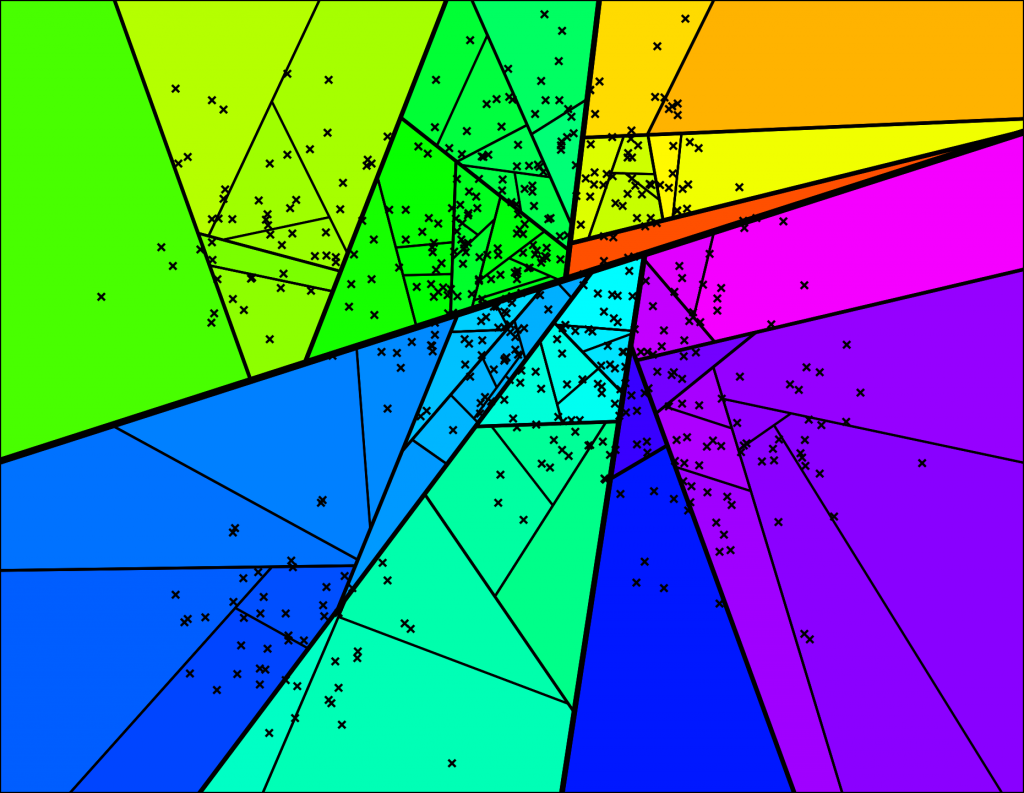

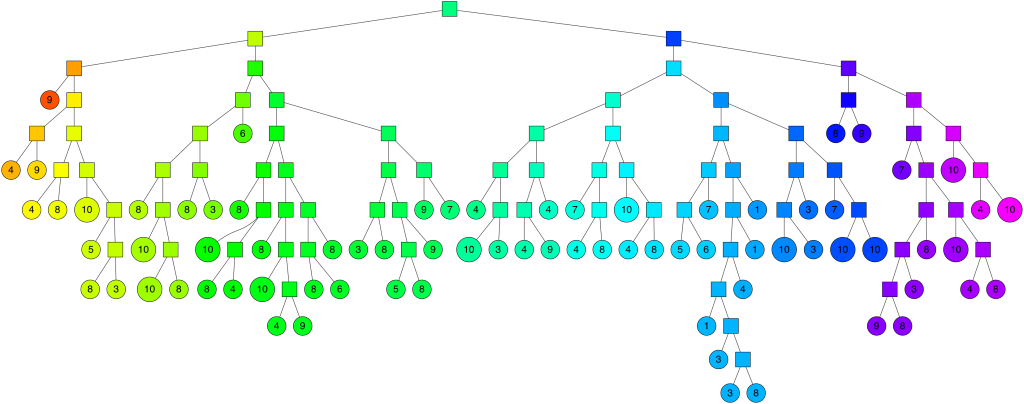

Source: Erik Bernhardsson. [*Nearest neighbors and vector models*](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html). 2015.

There are a few more details to this algorithm which are out of scope for this prac but if you'd like to learn more about it's inner workings, read this excellent [blog post](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html), by the author himself of ANNOY, Erik Bernhardsson.

Let's now create our ANNOY index. This process is slow and can take up to 10 minutes to run (perhaps you can read the blog post while you wait).

We first create the `AnnoyIndex` where we specify the size of our embedding (the $d$ from earlier) and the distance metric. Here `angular` refers to the cosine similarity. We then loop over our embeddings, adding them to our index.

Next we build our index by specifying the number of trees it should make. In the earlier explanation, we showed one tree being built but in reality the algorithm actually makes use of many. More trees results in greater accuracy but require more memory. In practice you will specify the number of trees that either max out your memory or until your desired level of accuracy is reached.

In [ ]:
from annoy import AnnoyIndex
ann = AnnoyIndex(cfg.EMB_DIM, "angular")
for i, vec in enumerate(item_embs):
    ann.add_item(i, vec.astype(np.float32))
ann.build(10)   # 10 trees

Let's again look at the most similar movies to this Avengers movie. We do this by calling the `get_nns_by_item` method and specifying the movie we would like to look up, the `n` (approximate) nearest neighbours we'd like to return, and `search_k` which refers to the number of embeddings it will consider for the distance calculation. The tradeoff made is that the higher the `search_k`, the more accurate it will be but the slower the performance. So in practice this number will be chosen by making sure it's as high as possible to maximise accuracy while making sure the results are returned in a time under the threshold you set for your application.

In [ ]:
# @title Quick ANN lookup vs exact
query = "Toy Story (1995)"
qid = movie2id[query]
print("🔎 ANNOY:")
display_recommendations(ann.get_nns_by_item(qid, 5, search_k=1000))

Let's compare the results to the exact search we performed before. How does it compare? What if we tweak the `search_k` above?

In [ ]:
print("\n🎯 Exact cosine:")
display_recommendations(most_similar(query, 5))

### **2.7. Types of Feedback**

To build recommender systems, there are two types of feedback we train our models against.
- **Explicit**: users specify whether or not they liked an item and sometimes even by how much. Examples of this are a thumbs up or thumbs down on a youtube video, review scores of a product, or even a movie rating!
- **Implicit**: the feedback is inferred based on how the users are interacting with the items. For example clicking an item, watching a video video, adding a product to your basket and/or purchasing.

The key differences between them is that explicit feedback is more sparse but gives you a higher confidence in to the users intent while implicit data is abundant but also noisier.

Usually both types of feedback are collected in the online services you use. Explicit feedback comes from the users naturally using the product (for e.g. reviewing the product) while the implicit data is usually coming from the telemetry infrastructure monitoring how users are interacting with your application. Depending on the maturity of this infrastructure, this can simply be logging what you're clicking on but can also include timing how long you've been on a page, the location your web requests are originating from, tracking exactly what content you've been exposed to, and even whether you simply hovered over an item and for how long. All of this data is logged and dumped into massive data stores to be later cleaned, analysed, and eventually trained on to create the recommender models.

These massive datasets are comprised of both implicit and explicit feedback along with the large recommender models trained on them is how the recommendations can sometimes feels so good. During your online life you're constantly expressing interest (or disinterest) implicitly by the simple usage of various internet platforms and this is all that is needed to figure out your preferences (especially when keeping in mind the thousands or even millions of people who might have interacted with the platform in similar ways). Now keep in mind how large these datasets and models can become. In this prac we built relatively small models on just 1MB of data and were still able to make plausible recommendations. They only get better when you scale them up.

It can be nerve wracking to realise how much of your data is harvested but at least now you can make a more informed decision about whether or not the quality of the recommendations you get is worth this tradeoff. Keep in mind, the purpose of these systems is to help you find the content you're looking for and discover content you might not have otherwise found. If this is still not worth it for you, luckily regulations are catching up and that it may start to become mandatory to allow users to opt out of personalised recommendations.

## Conclusion
**Summary:**

In this prac we introduced the general architecture of recommender systems and specifically focused on retrieving relevant items for users. We did this by demonstrating how Colaborative Filtering could be used for this task. Lastly we also described the type of data that's collected and how it's all crunched to construct the datasets used to build the recommender models.

**Next Steps:**

 - [Eugene Yan](https://eugeneyan.com/tag/recsys/) RecSys blog
 - [ACM RecSys YouTube](https://www.youtube.com/channel/UC2nEn-yNA1BtdDNWziphPGA)

**References:**

- Jeremy Howard & Silvain Gugger. [*Deep Learning for Coders with fastai and PyTorch*](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/). 2020. O'Reilly.
- Kim Falk. [*Practical Recommender Systems*](https://www.manning.com/books/practical-recommender-systems). 2019. Manning.
- [*Google Recommendation Systems Course*](https://developers.google.com/machine-learning/recommendation).